In [1]:
from pettingzoo.classic import connect_four_v3
import matplotlib.pyplot as plt 
import numpy as np
from IPython.display import clear_output
from gymnasium import spaces
import random
from pettingzoo.utils import agent_selector, wrappers
from copy import deepcopy
from Agents.RandomAgent import RandomAgent
from Run.run_episode import run_episode

from itertools import cycle

PLAYER_PIECE = 1
AI_PIECE = -1
EMPTY = 0
COLUMN_COUNT = 7
ROW_COUNT = 6
WINDOW_LENGTH = 4

# With pettingzoo

### Custom connect4 class (not working)

In [2]:
class CustomConnect4(connect_four_v3.raw_env):
    def __init__(self, render_mode):
        """
        The init method takes in environment arguments and
         should define the following attributes:
        - possible_agents
        - action_spaces
        - observation_spaces
        These attributes should not be changed after initialization.
        """
        super().__init__()
        self.screen = None
        self.render_mode = render_mode

        self.board = [0] * (6 * 7)

        self.agents = ["player_0", "player_1"]
        self.possible_agents = self.agents[:]

        self.action_spaces = {i: spaces.Discrete(7) for i in self.agents}
        self.observation_spaces = {
            i: spaces.Dict(
                {
                    "observation": spaces.Box(
                        low=0, high=1, shape=(6, 7, 2), dtype=np.int8
                    ),
                    "action_mask": spaces.Box(low=0, high=1, shape=(7,), dtype=np.int8),
                }
            )
            for i in self.agents
        }

    def get_board(self):
        observation, reward, termination, truncation, info = self.last()
        return (observation["observation"].T[0] + observation["observation"].T[1]*-1).T
    
    def evaluate_window(self, window, piece):
        """Evaluate the score of a window ie a range of """
        score = 0
        opp_piece = AI_PIECE if piece == PLAYER_PIECE else PLAYER_PIECE

        if window.count(piece) == 4:
            score += 100
        elif window.count(piece) == 3 and window.count(EMPTY) == 1:
            score += 5
        elif window.count(piece) == 2 and window.count(EMPTY) == 2:
            score += 2

        if window.count(opp_piece) == 3 and window.count(EMPTY) == 1:
            score -= 4

        return score


    def score_position(self, piece):
        score = 0
        board = self.get_board()
        ## Score center column
        center_array = [int(i) for i in list(board[:, COLUMN_COUNT//2])]
        center_count = center_array.count(piece)
        score += center_count * 3

        ## Score Horizontal
        for r in range(ROW_COUNT):
            row_array = [int(i) for i in list(board[r,:])]
            for c in range(COLUMN_COUNT-3):
                window = row_array[c:c+WINDOW_LENGTH]
                score += evaluate_window(window, piece)

        ## Score Vertical
        for c in range(COLUMN_COUNT):
            col_array = [int(i) for i in list(board[:,c])]
            for r in range(ROW_COUNT-3):
                window = col_array[r:r+WINDOW_LENGTH]
                score += evaluate_window(window, piece)

        ## Score positive sloped diagonal
        for r in range(ROW_COUNT-3):
            for c in range(COLUMN_COUNT-3):
                window = [board[r+i][c+i] for i in range(WINDOW_LENGTH)]
                score += evaluate_window(window, piece)

        ## Score negative sloped diagonal
        for r in range(ROW_COUNT-3):
            for c in range(COLUMN_COUNT-3):
                window = [board[r+3-i][c+i] for i in range(WINDOW_LENGTH)]
                score += evaluate_window(window, piece)

        return score


    def get_valid_locations(self, board):
        return None

    def is_terminal_node(self, board):
        return None

    def winning_move(self, board):
        return None

    def get_next_open_row(self, board, col):
        return None

    def drop_piece(board, row, col, AI_PIECE):
        return None

In [197]:
def create_custom_env(render_mode=None):
    env = CustomConnect4(render_mode=render_mode)
    env = wrappers.TerminateIllegalWrapper(env, illegal_reward=-1)
    return env

In [198]:
env = create_custom_env("rgb_array")

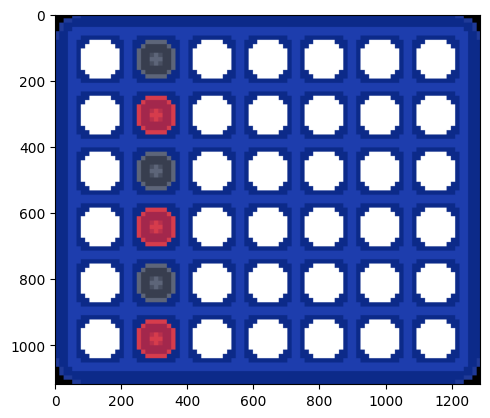

In [199]:
env.reset()
for agent in env.agent_iter():
    observation, reward, termination, truncation, info = env.last()
    if any(env.terminations.values()):
        break
    # action = policy(observation, agent)
    action = 1
    env.step(action)
    clear_output(wait=True)
    plt.imshow(env.render())
    plt.show()

### utils

In [61]:
AGENTS_PIECES = {
    "player_0": -1, 
    "player_1": 1
}

def display_board(env):
    clear_output(wait=True)
    plt.imshow(env.render())
    plt.show()


def get_board(env, agents_pieces: dict = AGENTS_PIECES):
        return sum(
            env.observe(agent_id)["observation"].T[0] * agent_value 
            for agent_id, agent_value in agents_pieces.items()
        ).T

def evaluate_window(window, piece: 1):
    """
    window : a range (row, col, diag) of the board
    
    """
    score = 0
    opp_piece = AI_PIECE if piece == PLAYER_PIECE else PLAYER_PIECE

    if window.count(piece) == 4:
        score += 100
    elif window.count(piece) == 3 and window.count(EMPTY) == 1:
        score += 5
    elif window.count(piece) == 2 and window.count(EMPTY) == 2:
        score += 2

    if window.count(opp_piece) == 3 and window.count(EMPTY) == 1:
        score -= 4

    return score


def score_position(env, agent: str):
    score = 0
    
    board = get_board(env)
    piece = AGENTS_PIECES[agent]
    
    ## Score center column
    center_array = [int(i) for i in list(board[:, COLUMN_COUNT//2])]
    center_count = center_array.count(piece)
    score += center_count * 3

    ## Score Horizontal
    for r in range(ROW_COUNT):
        row_array = [int(i) for i in list(board[r,:])]
        for c in range(COLUMN_COUNT-3):
            window = row_array[c:c+WINDOW_LENGTH]
            score += evaluate_window(window, piece)

    ## Score Vertical
    for c in range(COLUMN_COUNT):
        col_array = [int(i) for i in list(board[:,c])]
        for r in range(ROW_COUNT-3):
            window = col_array[r:r+WINDOW_LENGTH]
            score += evaluate_window(window, piece)

    ## Score positive sloped diagonal
    for r in range(ROW_COUNT-3):
        for c in range(COLUMN_COUNT-3):
            window = [board[r+i][c+i] for i in range(WINDOW_LENGTH)]
            score += evaluate_window(window, piece)

    for r in range(ROW_COUNT-3):
        for c in range(COLUMN_COUNT-3):
            window = [board[r+3-i][c+i] for i in range(WINDOW_LENGTH)]
            score += evaluate_window(window, piece)

    return score


def get_valid_locations(env, agent_id: str):
    action_mask = env.observe(agent_id)['action_mask']
    valid_locations = list(np.where(action_mask ==1)[0])
    return valid_locations

def is_terminal_node(env):
    return any(env.terminations.values())

def is_winning_move(env, agent_id: str):
    return env.rewards[agent_id] == 1

### Agent

In [6]:
class AlphaBetaAgent: 
    """
    Agent implementing Alpha Beta Prunning
    """
    def __init__(
        self,
        action_space, 
        observation_space,
        agent_id: str = "player_0",
        depth: int = 5
    ):
        self.action_space = action_space
        self.observation_space = observation_space
        self.agent_id = agent_id
        self.depth = depth
        
    def get_action(self, env, obs):
        alpha, beta = float("-inf"), float("inf")
        result = minimax(env, self.agent_id, self.depth, alpha, beta, True)
        return result[0]
    
    def update(self, obs, action, reward, terminated, next_obs):
        pass

In [103]:
def minimax(env, agent, depth, alpha, beta, maximizingPlayer):
    opponent = next(iter(ag for ag in env.possible_agents if ag != agent))
    player = agent if maximizingPlayer else opponent
    valid_locations = get_valid_locations(env, player)

    if is_terminal_node(env) or not valid_locations:
        if is_winning_move(env, agent):
            return None, float("inf")
        elif is_winning_move(env, opponent):
            return None, float("-inf")
        else: # Game is over, no more valid moves
            return None, 0
    elif depth == 0: # Depth is zero
        return None, score_position(env, agent)

    if maximizingPlayer:
        value = float("-inf")
        column = random.choice(valid_locations)
        for choice in valid_locations:
            copy_env = deepcopy(env)
            copy_env.step(choice)
            new_score = minimax(copy_env, agent, depth-1, alpha, beta, False)[1]
            if new_score > value:
                value = new_score
                column = choice
            alpha = max(alpha, value)
            if alpha >= beta:
                break
        return column, value


    else: # Minimizing player
        value = float("inf")
        column = random.choice(valid_locations)
        for choice in valid_locations:
            copy_env = deepcopy(env)
            copy_env.step(choice)
            new_score = minimax(copy_env, agent, depth-1, alpha, beta, True)[1]
            if new_score < value:
                value = new_score
                column = choice
            beta = min(beta, value)
            if alpha >= beta:
                break
        return column, value

In [104]:
env = connect_four_v3.env("rgb_array")
agents = [
    AlphaBetaAgent(env.action_space, env.observation_space, "player_0", depth=1),
    RandomAgent()
]
env.reset()

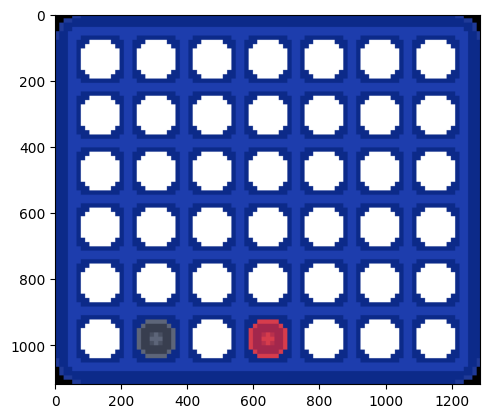

TypeError: cannot pickle 'pygame.surface.Surface' object

In [105]:
from time import sleep

for agent in cycle(agents):
    sleep(1)
    observation, reward, termination, truncation, info = env.last()
    if any(env.terminations.values()):
        break
    action = agent.get_action(copy(env), observation)
    if action is None:
        print(action)
        break
    env.step(action)
    clear_output(wait=True)
    plt.imshow(env.render())
    plt.show()

# Without pettingzoo

### static eval

In [9]:
import copy
import numpy as np
import matplotlib.pyplot as plt
from random import randint, choice


def static(Connect4):
    '''Evalue statiquement un plateau de jeu'''
    S = 0
    signe = {1: 1, 2: -1}
    good_positions = [{'1110', '1101', '1011', '0111'},
                      {'2220', '2202', '2022', '0222'}]
    win_positions = ['1111', '2222']

    for piece in [1, 2]:

        # Checks rows
        for r in range(Connect4.rows):
            ROW = str(int(Connect4.board[r][0]))
            for c in range(1, Connect4.cols):
                ROW += str(int(Connect4.board[r][c]))
            for start_index in range(len(ROW) - 3):
                if ROW[start_index:start_index + 4] in good_positions[piece-1]:
                    S += signe[piece]*10
                if ROW[start_index:start_index + 4] in win_positions[piece-1]:
                    S += signe[piece]*1000
        # Checks columns
        for c in range(Connect4.cols):
            COL = str(int(Connect4.board[0][c]))
            for r in range(1, Connect4.rows):
                COL += str(int(Connect4.board[r][c]))
            for start_index in range(len(COL) - 3):
                if COL[start_index:start_index + 4] in good_positions[piece-1]:
                    S += signe[piece]*10
                if COL[start_index:start_index + 4] in win_positions[piece-1]:
                    S += signe[piece]*1000

        # Checks positively sloped diagonals
        for c in range(Connect4.cols-3):
            for r in range(Connect4.rows-3):
                DIAG = str(int(Connect4.board[r][c]))
                for i in range(1, 4):
                    DIAG += str(int(Connect4.board[r+i][c+i]))
                for start_index in range(len(DIAG) - 3):
                    if DIAG[start_index:start_index + 4] in good_positions[piece-1]:
                        S += signe[piece]*10
                    if DIAG[start_index:start_index + 4] in win_positions[piece-1]:
                        S += signe[piece]*1000

        # Checks negatively sloped diagonals
        for c in range(Connect4.cols-3):
            for r in range(3, Connect4.rows):
                DIAG = str(int(Connect4.board[r][c]))
                for i in range(1, 4):
                    DIAG += str(int(Connect4.board[r-i][c+i]))
                for start_index in range(len(DIAG) - 3):
                    if DIAG[start_index:start_index + 4] in good_positions[piece-1]:
                        S += signe[piece]*10
                    if DIAG[start_index:start_index + 4] in win_positions[piece-1]:
                        S += signe[piece]*1000

    return S

### implementation

In [117]:
import numpy as np
import pygame
import copy
import sys
import math
import time
from random import choice

def get_children(Connect4):
    '''Returns a dictionnary {move:obtained_child}'''
    dict_children = {}
    for col in range(Connect4.cols):
        if Connect4.move_is_valid(col):
            Child = copy.deepcopy(Connect4)
            children_piece = Connect4.turn + 1
            Child.play_move(col, children_piece)
            Child.turn = 1 - Connect4.turn
            if Child.check_wins(children_piece) or not moves(Child):
                Child.game_over = True
            dict_children[str(col)] = Child
    if not dict_children and not Connect4.game_over:
        Connect4.game_over = True
    return dict_children


def moves(Connect4):
    '''Returns an array of available moves from current state'''
    L = set()
    for col in range(Connect4.cols):
        if Connect4.move_is_valid(col):
            L.add(col)
    if not L:
        Connect4.game_over = True
    return L


def minimax(Connect4, depth, alpha, beta, maximizingPlayer=None):
    '''Returns best possible score obtained from the root'''
    if maximizingPlayer == None:
        maximizingPlayer = not bool(Connect4.turn)

    if depth == 0 or Connect4.game_over:
        return static(Connect4)

    elif maximizingPlayer:
        maxEval = float('-inf')
        for child in get_children(Connect4).values():
            eval = minimax(child, depth - 1, alpha, beta, False)
            maxEval = max(maxEval, eval)
            alpha = max(alpha, eval)
            if beta <= alpha:
                break
        return maxEval

    else:
        minEval = float('inf')
        for child in get_children(Connect4).values():
            eval = minimax(child, depth - 1, alpha, beta, True)
            minEval = min(minEval, eval)
            beta = min(beta, eval)
            if beta <= alpha:
                break
        return minEval


def best_move(Connect4, depth: int = 3):
    '''Returns best possible move from current state, based on alphabeta prunning algorithm'''
    # Player 1 has here turn 0 and plays as MAX
    if not Connect4.game_over:
        possible_moves = moves(Connect4)
        scores = [float('inf')]*Connect4.cols if Connect4.turn else [float('-inf')]*Connect4.cols
        
        children = get_children(Connect4)
        for playable_move in children.keys():
            scores[int(playable_move)] = minimax(
                children[playable_move],
                depth=depth, 
                alpha=-float('inf'),
                beta=float('inf'), 
                maximizingPlayer=not children[playable_move].turn
            )

        hyp_move = scores.index(max(scores))
        # Unplayable moves get NaN score
        for col in range(Connect4.cols):
            if col not in possible_moves:
                scores[col] = float('nan')

        if Connect4.turn == 0:
            # Children score is then maximized
            if abs(np.nanmean(scores)) != float('inf'):
                if max(scores) == int(np.nanmean(scores)):
                    if not max(scores) and 3 in possible_moves:
                        move = 3
                        return move
                    else:
                        move = choice(list(possible_moves))
                        return move
                else:
                    move = hyp_move
                    return move
        else:
            # Children score is minimized
            move = scores.index(min(scores))
            return move

        
class Connect4:
    ''' Some methods assume that the board has a 6x7 size'''

    def __init__(self, nb_rows=6, nb_cols=7, board: np.ndarray = None):
        self.rows = nb_rows
        self.cols = nb_cols
        self.board = board if board is not None else np.zeros((nb_rows, nb_cols))
        self.game_over = False
        self.turn = 0
        self.winner = None

    def play_move(self, col, piece):
        row = max(np.where(self.board[:, col] == 0)[0])
        self.board[row, col] = piece

    def get_available_col(self):
        return np.where(game.board[:, game.cols-1] == 0)[0]
    
    def move_is_valid(self, col):
        return self.board[0, col] == 0

    def check_wins(self, piece):
        # Check horizontal locations for win
        for c in range(self.cols-3):
            for r in range(self.rows):
                if self.board[r][c] == piece and self.board[r][c+1] == piece and self.board[r][c+2] == piece and self.board[r][c+3] == piece:
                    return True

        # Check vertical locations for win
        for c in range(self.cols):
            for r in range(self.rows-3):
                if self.board[r][c] == piece and self.board[r+1][c] == piece and self.board[r+2][c] == piece and self.board[r+3][c] == piece:
                    return True

        # Check positively sloped diaganols
        for c in range(self.cols-3):
            for r in range(self.rows-3):
                if self.board[r][c] == piece and self.board[r+1][c+1] == piece and self.board[r+2][c+2] == piece and self.board[r+3][c+3] == piece:
                    return True

        # Check negatively sloped diaganols
        for c in range(self.cols-3):
            for r in range(3, self.rows):
                if self.board[r][c] == piece and self.board[r-1][c+1] == piece and self.board[r-2][c+2] == piece and self.board[r-3][c+3] == piece:
                    return True
        
    def play(self):
        '''Allows you to play as Player 2 against Minimax'''

        while not self.game_over:
            if self.turn == 0:
                col = best_move(self, self.depth)
                self.play_move(col, 1)

                if self.check_wins(1):
                    self.game_over = True
                    break
                self.turn = 1 - self.turn
            if self.turn == 1:
                available_cols = self.get_available_col()
                col = random.choice(available_cols)
                self.play_move(col, 2)

                if self.check_wins(1):
                    self.game_over = True
                    break
                self.turn = 1 - self.turn

# Merge approaches

### Test

In [104]:
AGENTS_PIECES = {"player_0": 1, "player_1": 2}
def get_board(env, agents_pieces: dict = AGENTS_PIECES):
    return sum(
        env.observe(agent_id)["observation"].T[0] * agent_value 
        for agent_id, agent_value in agents_pieces.items()
    ).T

In [105]:
env = connect_four_v3.env("rgb_array")

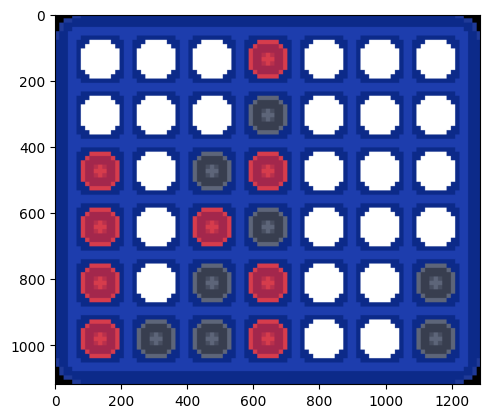

In [ ]:
env.reset()
for agent in env.agent_iter():
    if any(env.terminations.values()):
        break
    
    if agent == "player_0":
        connect_4 = Connect4(6, 7, get_board(env))
        action = best_move(connect_4)

    else:
        possible_actions = np.where(env.observe(agent)["action_mask"] == 1)[0]
        action = random.choice(possible_actions)
    env.step(action)
    clear_output(wait=True)
    plt.imshow(env.render())
    plt.show()

### Implementation

In [154]:
observation = env.last()[0]["observation"]

In [160]:
sum(
    observation.T[idx]* agent_value 
    for idx, (_, agent_value) in enumerate(AGENTS_PIECES.items())
).T

array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [2, 1, 0, 0, 0, 0, 0],
       [1, 2, 1, 1, 0, 0, 0],
       [2, 1, 2, 1, 2, 2, 0]], dtype=int8)

In [124]:
class AlphaBetaAgent: 
    """
    Agent implementing Alpha Beta Prunning
    """
    def __init__(
        self,
        action_space, 
        observation_space,
        depth: int = 5
    ):
        self.action_space = action_space
        self.observation_space = observation_space
        self.depth = depth
        
    def get_action(self, env, obs):
        alpha, beta = float("-inf"), float("inf")
        connect_4_copy = Connect4(board=get_board(env))
        return best_move(connect_4_copy, self.depth)
    
    def update(self, obs, action, reward, terminated, next_obs):
        pass

In [125]:
env = connect_four_v3.env("rgb_array")
agents = [
    AlphaBetaAgent(env.action_space, env.observation_space, depth=4),
    RandomAgent()
]
env.reset()

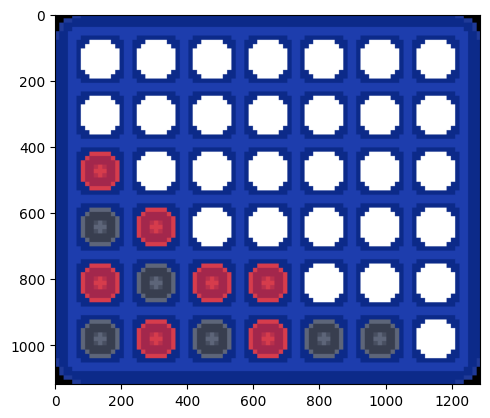

In [126]:
from time import sleep

for agent in cycle(agents):
    sleep(1)
    observation, reward, termination, truncation, info = env.last()
    if any(env.terminations.values()):
        break
    action = agent.get_action(copy.copy(env), observation)
    env.step(action)
    clear_output(wait=True)
    plt.imshow(env.render())
    plt.show()

In [1]:
from Agents.AlphaBetaAgent import AlphaBetaAgent
from Agents.RandomAgent import RandomAgent
from Run.run_episode import run_episode

In [3]:
from pettingzoo.classic import connect_four_v3
env = connect_four_v3.env("rgb_array")
agents = [
    AlphaBetaAgent(env.action_space, env.observation_space, depth=4),
    AlphaBetaAgent(env.action_space, env.observation_space, depth=2)
]
env.reset()

run_episode(env, agents, display=True)


KeyboardInterrupt

